# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

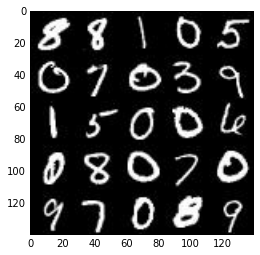

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

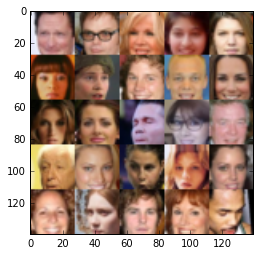

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_size = (image_width, image_height, image_channels)
    inputs_real = tf.placeholder(tf.float32, (None,*real_size), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate_placeholder = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate_placeholder


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [14]:
def leaky_relu(data, alpha=0.01):
    return tf.maximum(alpha*data, data)

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # input dim is 28 x 28 x num channels (1 for mnist, 3 for faces)
        x1 = tf.layers.conv2d(images,64,5,strides=2, padding='same')
        relu1 = leaky_relu(x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 2*64, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2)
        # 7x7x128
        
        # flatten
        flat = tf.reshape(relu2, (-1,7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    

    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim,is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        dense1 = tf.layers.dense(z, 7*7*512)
        reshaped1 = tf.reshape(dense1, (-1,7,7,512))
        bn1 = tf.layers.batch_normalization(reshaped1, training=is_train)
        relu1 = leaky_relu(bn1)
        # 7x7x512
        
        conv2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=is_train)
        relu2 = leaky_relu(bn2)
        # 14x14x256
                                            
        # out_channel_dim is 1 for mnist and 3 for faces, i.e. color dim
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim,5, 
                                            strides=2,padding='same' )
        # 28x28x output_dim
        out = tf.tanh(logits)
                
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                               labels = tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                               labels = tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                               labels = tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS,scope='discriminator')):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
       
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [45]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, 
          get_batches, data_shape, data_image_mode, show_every=100, 
          print_every=10, n_images=16):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    print(z_dim)
    print(data_shape)
    (num_images, image_width, image_height, image_channels) = data_shape
    
    input_real, input_z, learning_rate_placeholder = model_inputs(image_width, image_height, image_channels, z_dim)
    
    print("TYPE input_z:", type(input_z))
    # out_channel_dim = image_channels
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # TODO: learning_rate init? 
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver() # TODO: perhaps only generator variables 
    samples, losses = [], []
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):      
                steps += 1
                # TODO: Train Model
                #print("b", batch_images.shape)
                
                # input data batches has values from -0.5 to 0.5 => scale to -1 to 1
                batch_images *= 2.0
                
                # sample random noise for G
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))
            
                # run discriminator and generator optimizers
                _ = sess.run(d_opt, feed_dict={input_real:batch_images,
                                              input_z:batch_z,
                                              learning_rate_placeholder:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real:batch_images,
                                              input_z:batch_z,
                                              learning_rate_placeholder:learning_rate})
                
                if steps % print_every == 0:
                    # get losses and print them out
                    train_loss_d = sess.run(d_loss, {input_real:batch_images,
                                              input_z:batch_z,
                                              learning_rate_placeholder:learning_rate})
                    train_loss_g = g_loss.eval({input_real:batch_images,
                                              input_z:batch_z,
                                              learning_rate_placeholder:learning_rate})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g)) 
            
                if steps % show_every  == 0:
                    print(type(batch_z))
                    show_generator_output(sess, n_images=n_images,
                                         input_z=input_z, out_channel_dim=image_channels,
                                         image_mode=data_image_mode)

    # save training generator samples
    with open('train_samples_pkl','wb') as fh:
        import pickle as pkl
        pkl.dump(samples,fh)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

100
(60000, 28, 28, 1)
TYPE input_z: <class 'tensorflow.python.framework.ops.Tensor'>
Epoch 1/2... Discriminator Loss: 1.3194... Generator Loss: 0.4894
Epoch 1/2... Discriminator Loss: 1.1617... Generator Loss: 0.6386
Epoch 1/2... Discriminator Loss: 1.5749... Generator Loss: 0.6243
Epoch 1/2... Discriminator Loss: 1.2448... Generator Loss: 0.7370
Epoch 1/2... Discriminator Loss: 1.6434... Generator Loss: 0.5419
Epoch 1/2... Discriminator Loss: 1.3781... Generator Loss: 0.6567
Epoch 1/2... Discriminator Loss: 1.2236... Generator Loss: 0.7906
Epoch 1/2... Discriminator Loss: 1.3438... Generator Loss: 0.6880
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.6992
Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 0.7233
<class 'numpy.ndarray'>


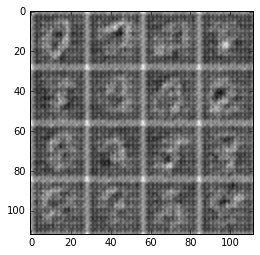

Epoch 1/2... Discriminator Loss: 1.2612... Generator Loss: 0.6591
Epoch 1/2... Discriminator Loss: 1.2463... Generator Loss: 0.9614
Epoch 1/2... Discriminator Loss: 1.2964... Generator Loss: 0.5619
Epoch 1/2... Discriminator Loss: 1.1938... Generator Loss: 1.0122
Epoch 1/2... Discriminator Loss: 1.1618... Generator Loss: 0.8232
Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 0.5425
Epoch 1/2... Discriminator Loss: 1.1633... Generator Loss: 0.6471
Epoch 1/2... Discriminator Loss: 1.1253... Generator Loss: 0.9901
Epoch 1/2... Discriminator Loss: 1.1779... Generator Loss: 1.1587
Epoch 1/2... Discriminator Loss: 1.0952... Generator Loss: 0.9501
<class 'numpy.ndarray'>


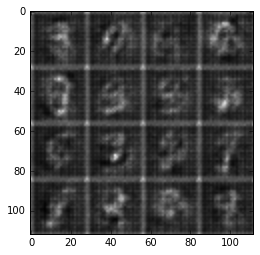

Epoch 1/2... Discriminator Loss: 1.0782... Generator Loss: 0.8190
Epoch 1/2... Discriminator Loss: 1.0588... Generator Loss: 0.9228
Epoch 1/2... Discriminator Loss: 1.1526... Generator Loss: 1.1492
Epoch 1/2... Discriminator Loss: 1.0337... Generator Loss: 0.7918
Epoch 1/2... Discriminator Loss: 0.9593... Generator Loss: 0.9786
Epoch 1/2... Discriminator Loss: 1.0717... Generator Loss: 0.7231
Epoch 1/2... Discriminator Loss: 1.0244... Generator Loss: 1.0343
Epoch 1/2... Discriminator Loss: 0.9933... Generator Loss: 0.9917
Epoch 1/2... Discriminator Loss: 0.9996... Generator Loss: 1.1098
Epoch 1/2... Discriminator Loss: 0.9652... Generator Loss: 0.9432
<class 'numpy.ndarray'>


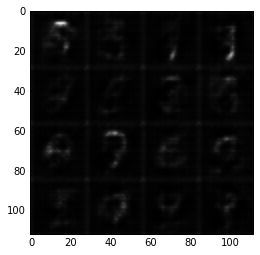

Epoch 1/2... Discriminator Loss: 1.1202... Generator Loss: 1.5542
Epoch 1/2... Discriminator Loss: 1.0599... Generator Loss: 0.9410
Epoch 1/2... Discriminator Loss: 0.9484... Generator Loss: 0.9756
Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 0.7986
Epoch 1/2... Discriminator Loss: 1.0051... Generator Loss: 1.2495
Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 1.4333
Epoch 1/2... Discriminator Loss: 1.0539... Generator Loss: 0.7581
Epoch 1/2... Discriminator Loss: 1.1043... Generator Loss: 0.6533
Epoch 1/2... Discriminator Loss: 1.0831... Generator Loss: 0.7563
Epoch 1/2... Discriminator Loss: 1.0593... Generator Loss: 1.0537
<class 'numpy.ndarray'>


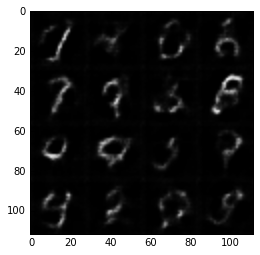

Epoch 1/2... Discriminator Loss: 1.0309... Generator Loss: 0.8808
Epoch 1/2... Discriminator Loss: 1.1153... Generator Loss: 0.7558
Epoch 1/2... Discriminator Loss: 1.1613... Generator Loss: 1.1474
Epoch 1/2... Discriminator Loss: 1.1772... Generator Loss: 1.1238
Epoch 1/2... Discriminator Loss: 1.1559... Generator Loss: 0.7012
Epoch 1/2... Discriminator Loss: 1.1660... Generator Loss: 0.6331
Epoch 2/2... Discriminator Loss: 1.1312... Generator Loss: 0.8480
Epoch 2/2... Discriminator Loss: 1.1332... Generator Loss: 1.0274
Epoch 2/2... Discriminator Loss: 1.2113... Generator Loss: 0.6027
Epoch 2/2... Discriminator Loss: 1.1558... Generator Loss: 1.1209
<class 'numpy.ndarray'>


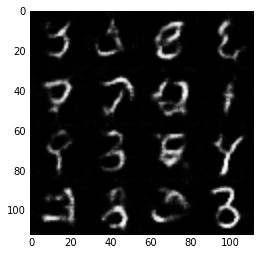

Epoch 2/2... Discriminator Loss: 1.2080... Generator Loss: 1.1510
Epoch 2/2... Discriminator Loss: 1.2053... Generator Loss: 0.7473
Epoch 2/2... Discriminator Loss: 1.1819... Generator Loss: 0.7776
Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 0.5517
Epoch 2/2... Discriminator Loss: 1.1476... Generator Loss: 0.7518
Epoch 2/2... Discriminator Loss: 1.1901... Generator Loss: 0.6195
Epoch 2/2... Discriminator Loss: 1.1493... Generator Loss: 0.7765
Epoch 2/2... Discriminator Loss: 1.1856... Generator Loss: 1.0572
Epoch 2/2... Discriminator Loss: 1.1547... Generator Loss: 0.5882
Epoch 2/2... Discriminator Loss: 1.1316... Generator Loss: 0.9455
<class 'numpy.ndarray'>


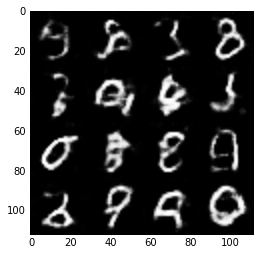

Epoch 2/2... Discriminator Loss: 1.1610... Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 1.2002... Generator Loss: 0.8531
Epoch 2/2... Discriminator Loss: 1.1603... Generator Loss: 1.0187
Epoch 2/2... Discriminator Loss: 1.1939... Generator Loss: 0.8550
Epoch 2/2... Discriminator Loss: 1.3045... Generator Loss: 0.4460
Epoch 2/2... Discriminator Loss: 1.1450... Generator Loss: 0.9751
Epoch 2/2... Discriminator Loss: 1.1548... Generator Loss: 0.9684
Epoch 2/2... Discriminator Loss: 1.1570... Generator Loss: 0.7137
Epoch 2/2... Discriminator Loss: 1.1676... Generator Loss: 1.0009
Epoch 2/2... Discriminator Loss: 1.1374... Generator Loss: 0.7377
<class 'numpy.ndarray'>


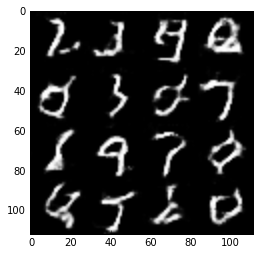

Epoch 2/2... Discriminator Loss: 1.1091... Generator Loss: 0.7295
Epoch 2/2... Discriminator Loss: 1.1303... Generator Loss: 0.9871
Epoch 2/2... Discriminator Loss: 1.2668... Generator Loss: 0.5077
Epoch 2/2... Discriminator Loss: 1.1301... Generator Loss: 0.7460
Epoch 2/2... Discriminator Loss: 1.1656... Generator Loss: 0.7026
Epoch 2/2... Discriminator Loss: 1.2196... Generator Loss: 0.5548
Epoch 2/2... Discriminator Loss: 1.1652... Generator Loss: 0.5767
Epoch 2/2... Discriminator Loss: 1.1534... Generator Loss: 0.6902
Epoch 2/2... Discriminator Loss: 1.1117... Generator Loss: 0.8924
Epoch 2/2... Discriminator Loss: 0.9845... Generator Loss: 0.9951
<class 'numpy.ndarray'>


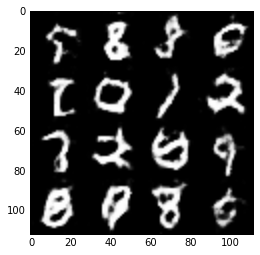

Epoch 2/2... Discriminator Loss: 1.1661... Generator Loss: 0.9578
Epoch 2/2... Discriminator Loss: 1.1043... Generator Loss: 0.7401
Epoch 2/2... Discriminator Loss: 1.0791... Generator Loss: 1.0428
Epoch 2/2... Discriminator Loss: 1.0687... Generator Loss: 1.0827
Epoch 2/2... Discriminator Loss: 1.0560... Generator Loss: 0.8815
Epoch 2/2... Discriminator Loss: 1.1257... Generator Loss: 0.6345
Epoch 2/2... Discriminator Loss: 1.0764... Generator Loss: 0.8907
Epoch 2/2... Discriminator Loss: 1.0140... Generator Loss: 1.1854
Epoch 2/2... Discriminator Loss: 1.1270... Generator Loss: 0.6528
Epoch 2/2... Discriminator Loss: 1.0081... Generator Loss: 0.8475
<class 'numpy.ndarray'>


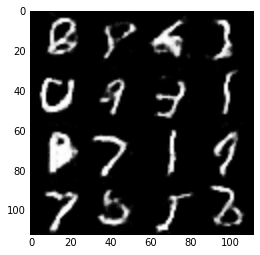

Epoch 2/2... Discriminator Loss: 1.0164... Generator Loss: 0.9297
Epoch 2/2... Discriminator Loss: 1.1245... Generator Loss: 0.6262
Epoch 2/2... Discriminator Loss: 1.1387... Generator Loss: 0.5983


In [46]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

100
(202599, 28, 28, 3)
TYPE input_z: <class 'tensorflow.python.framework.ops.Tensor'>
Epoch 1/3... Discriminator Loss: 2.1591... Generator Loss: 0.2591
Epoch 1/3... Discriminator Loss: 2.2413... Generator Loss: 0.2561
Epoch 1/3... Discriminator Loss: 1.4620... Generator Loss: 0.8055
Epoch 1/3... Discriminator Loss: 1.2745... Generator Loss: 0.8720
Epoch 1/3... Discriminator Loss: 1.1665... Generator Loss: 0.9206
Epoch 1/3... Discriminator Loss: 1.4762... Generator Loss: 0.7298
Epoch 1/3... Discriminator Loss: 1.6138... Generator Loss: 0.6418
Epoch 1/3... Discriminator Loss: 1.4909... Generator Loss: 0.7051
Epoch 1/3... Discriminator Loss: 1.3663... Generator Loss: 0.7761
Epoch 1/3... Discriminator Loss: 1.5357... Generator Loss: 0.6333
<class 'numpy.ndarray'>


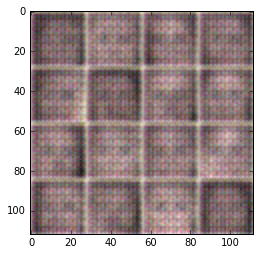

Epoch 1/3... Discriminator Loss: 1.6738... Generator Loss: 0.5807
Epoch 1/3... Discriminator Loss: 1.2838... Generator Loss: 0.8391
Epoch 1/3... Discriminator Loss: 1.5072... Generator Loss: 0.6173
Epoch 1/3... Discriminator Loss: 1.5861... Generator Loss: 0.5044
Epoch 1/3... Discriminator Loss: 1.5237... Generator Loss: 0.6662
Epoch 1/3... Discriminator Loss: 1.4623... Generator Loss: 0.5767
Epoch 1/3... Discriminator Loss: 1.4152... Generator Loss: 0.6880
Epoch 1/3... Discriminator Loss: 1.3130... Generator Loss: 0.7896
Epoch 1/3... Discriminator Loss: 1.2439... Generator Loss: 0.8637
Epoch 1/3... Discriminator Loss: 1.1933... Generator Loss: 0.9535
<class 'numpy.ndarray'>


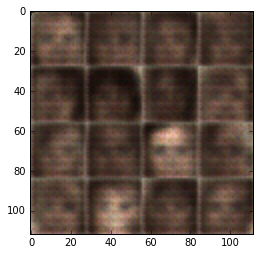

Epoch 1/3... Discriminator Loss: 1.3388... Generator Loss: 0.9002
Epoch 1/3... Discriminator Loss: 1.5317... Generator Loss: 0.3774
Epoch 1/3... Discriminator Loss: 0.9568... Generator Loss: 1.2344
Epoch 1/3... Discriminator Loss: 1.1740... Generator Loss: 1.1656
Epoch 1/3... Discriminator Loss: 1.1026... Generator Loss: 0.8151
Epoch 1/3... Discriminator Loss: 1.0839... Generator Loss: 1.3236
Epoch 1/3... Discriminator Loss: 0.6142... Generator Loss: 2.0245
Epoch 1/3... Discriminator Loss: 0.6640... Generator Loss: 1.8393
Epoch 1/3... Discriminator Loss: 1.4019... Generator Loss: 1.9646
Epoch 1/3... Discriminator Loss: 0.6395... Generator Loss: 1.8144
<class 'numpy.ndarray'>


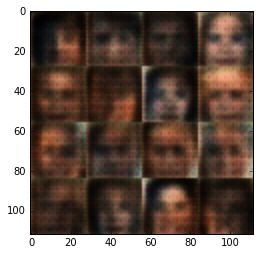

Epoch 1/3... Discriminator Loss: 0.5385... Generator Loss: 1.4829
Epoch 1/3... Discriminator Loss: 0.5859... Generator Loss: 2.0760
Epoch 1/3... Discriminator Loss: 0.5742... Generator Loss: 2.1127
Epoch 1/3... Discriminator Loss: 0.5991... Generator Loss: 1.4650
Epoch 1/3... Discriminator Loss: 0.4164... Generator Loss: 4.1785
Epoch 1/3... Discriminator Loss: 0.8946... Generator Loss: 4.6762
Epoch 1/3... Discriminator Loss: 0.2949... Generator Loss: 2.4541
Epoch 1/3... Discriminator Loss: 0.1545... Generator Loss: 4.4725
Epoch 1/3... Discriminator Loss: 0.3501... Generator Loss: 1.6650
Epoch 1/3... Discriminator Loss: 1.9023... Generator Loss: 0.2083
<class 'numpy.ndarray'>


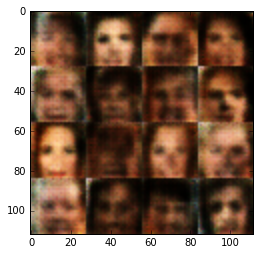

Epoch 1/3... Discriminator Loss: 0.1646... Generator Loss: 4.9349
Epoch 1/3... Discriminator Loss: 0.4526... Generator Loss: 5.3154
Epoch 1/3... Discriminator Loss: 0.1710... Generator Loss: 2.9444
Epoch 1/3... Discriminator Loss: 0.4192... Generator Loss: 1.6352
Epoch 1/3... Discriminator Loss: 0.4123... Generator Loss: 2.0556
Epoch 1/3... Discriminator Loss: 0.2575... Generator Loss: 4.6268
Epoch 1/3... Discriminator Loss: 0.2193... Generator Loss: 3.1099
Epoch 1/3... Discriminator Loss: 0.1725... Generator Loss: 4.0758
Epoch 1/3... Discriminator Loss: 0.3949... Generator Loss: 1.6770
Epoch 1/3... Discriminator Loss: 0.2251... Generator Loss: 3.4510
<class 'numpy.ndarray'>


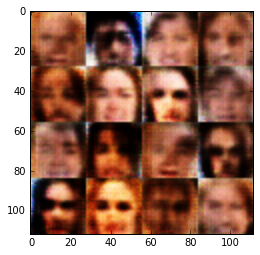

Epoch 1/3... Discriminator Loss: 0.7092... Generator Loss: 5.5213
Epoch 1/3... Discriminator Loss: 0.5164... Generator Loss: 4.7719
Epoch 1/3... Discriminator Loss: 1.3506... Generator Loss: 0.4550
Epoch 1/3... Discriminator Loss: 0.2550... Generator Loss: 2.3703
Epoch 1/3... Discriminator Loss: 0.1686... Generator Loss: 3.2883
Epoch 1/3... Discriminator Loss: 0.2542... Generator Loss: 2.8960
Epoch 1/3... Discriminator Loss: 0.3095... Generator Loss: 1.8512
Epoch 1/3... Discriminator Loss: 0.2652... Generator Loss: 2.8770
Epoch 1/3... Discriminator Loss: 0.9410... Generator Loss: 4.7507
Epoch 1/3... Discriminator Loss: 0.8777... Generator Loss: 0.8898
<class 'numpy.ndarray'>


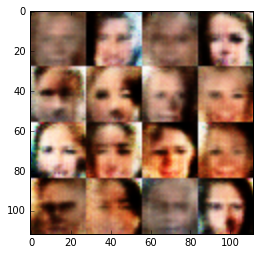

Epoch 1/3... Discriminator Loss: 1.6640... Generator Loss: 0.2940
Epoch 1/3... Discriminator Loss: 0.1746... Generator Loss: 5.5593
Epoch 1/3... Discriminator Loss: 1.1631... Generator Loss: 0.5193
Epoch 1/3... Discriminator Loss: 0.7911... Generator Loss: 0.8250
Epoch 1/3... Discriminator Loss: 1.5438... Generator Loss: 1.0078
Epoch 1/3... Discriminator Loss: 0.5831... Generator Loss: 5.9728
Epoch 1/3... Discriminator Loss: 1.7957... Generator Loss: 2.7357
Epoch 1/3... Discriminator Loss: 1.5457... Generator Loss: 0.6106
Epoch 1/3... Discriminator Loss: 0.3982... Generator Loss: 3.1841
Epoch 1/3... Discriminator Loss: 1.2712... Generator Loss: 0.8062
<class 'numpy.ndarray'>


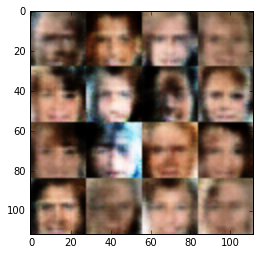

Epoch 1/3... Discriminator Loss: 0.8576... Generator Loss: 0.7601
Epoch 1/3... Discriminator Loss: 0.5898... Generator Loss: 1.7271
Epoch 1/3... Discriminator Loss: 1.3212... Generator Loss: 0.8591
Epoch 1/3... Discriminator Loss: 1.5127... Generator Loss: 0.3422
Epoch 1/3... Discriminator Loss: 0.7487... Generator Loss: 1.4229
Epoch 1/3... Discriminator Loss: 1.4371... Generator Loss: 0.7662
Epoch 1/3... Discriminator Loss: 0.5854... Generator Loss: 7.3479
Epoch 1/3... Discriminator Loss: 1.1405... Generator Loss: 1.2010
Epoch 1/3... Discriminator Loss: 1.5630... Generator Loss: 0.6730
Epoch 1/3... Discriminator Loss: 0.5662... Generator Loss: 2.2866
<class 'numpy.ndarray'>


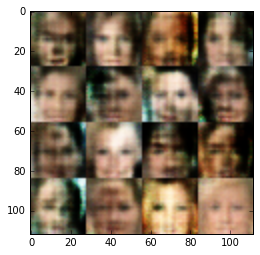

Epoch 1/3... Discriminator Loss: 1.4451... Generator Loss: 0.6311
Epoch 1/3... Discriminator Loss: 0.3460... Generator Loss: 1.9896
Epoch 1/3... Discriminator Loss: 1.9958... Generator Loss: 0.1935
Epoch 1/3... Discriminator Loss: 1.4339... Generator Loss: 0.6461
Epoch 1/3... Discriminator Loss: 1.1713... Generator Loss: 0.6603
Epoch 1/3... Discriminator Loss: 0.6782... Generator Loss: 2.2125
Epoch 1/3... Discriminator Loss: 1.2920... Generator Loss: 0.6982
Epoch 1/3... Discriminator Loss: 0.6382... Generator Loss: 4.9693
Epoch 1/3... Discriminator Loss: 1.3443... Generator Loss: 0.6049
Epoch 1/3... Discriminator Loss: 1.4984... Generator Loss: 0.6790
<class 'numpy.ndarray'>


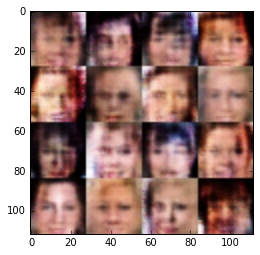

Epoch 1/3... Discriminator Loss: 2.4387... Generator Loss: 0.1133
Epoch 1/3... Discriminator Loss: 1.3220... Generator Loss: 0.7562
Epoch 1/3... Discriminator Loss: 0.2997... Generator Loss: 3.3925
Epoch 1/3... Discriminator Loss: 1.6347... Generator Loss: 0.7815
Epoch 1/3... Discriminator Loss: 1.4781... Generator Loss: 0.5926
Epoch 1/3... Discriminator Loss: 0.2705... Generator Loss: 3.7118
Epoch 1/3... Discriminator Loss: 1.3661... Generator Loss: 0.5878
Epoch 1/3... Discriminator Loss: 0.2426... Generator Loss: 3.9881
Epoch 1/3... Discriminator Loss: 1.3081... Generator Loss: 0.7050
Epoch 1/3... Discriminator Loss: 0.1838... Generator Loss: 3.1350
<class 'numpy.ndarray'>


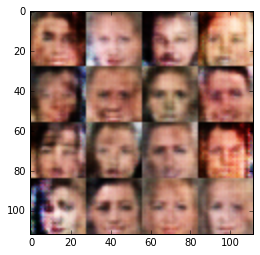

Epoch 1/3... Discriminator Loss: 1.4644... Generator Loss: 0.4725
Epoch 1/3... Discriminator Loss: 1.2641... Generator Loss: 0.6159
Epoch 1/3... Discriminator Loss: 0.5278... Generator Loss: 1.6223
Epoch 1/3... Discriminator Loss: 0.3649... Generator Loss: 2.6207
Epoch 1/3... Discriminator Loss: 0.4820... Generator Loss: 2.4031
Epoch 1/3... Discriminator Loss: 1.0734... Generator Loss: 0.6995
Epoch 1/3... Discriminator Loss: 0.9677... Generator Loss: 1.2757
Epoch 1/3... Discriminator Loss: 0.5629... Generator Loss: 1.3711
Epoch 1/3... Discriminator Loss: 0.7442... Generator Loss: 1.3384
Epoch 1/3... Discriminator Loss: 0.7307... Generator Loss: 1.9932
<class 'numpy.ndarray'>


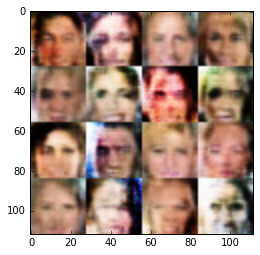

Epoch 1/3... Discriminator Loss: 1.3386... Generator Loss: 0.4048
Epoch 1/3... Discriminator Loss: 0.4043... Generator Loss: 1.7798
Epoch 1/3... Discriminator Loss: 0.9409... Generator Loss: 0.7028
Epoch 1/3... Discriminator Loss: 0.5215... Generator Loss: 2.2642
Epoch 1/3... Discriminator Loss: 0.4906... Generator Loss: 1.6874
Epoch 1/3... Discriminator Loss: 0.7181... Generator Loss: 1.0054
Epoch 1/3... Discriminator Loss: 0.4509... Generator Loss: 1.9769
Epoch 1/3... Discriminator Loss: 2.0385... Generator Loss: 0.1710
Epoch 1/3... Discriminator Loss: 0.1805... Generator Loss: 5.4676
Epoch 1/3... Discriminator Loss: 0.9580... Generator Loss: 0.7182
<class 'numpy.ndarray'>


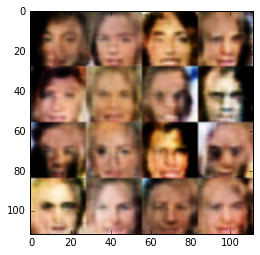

Epoch 1/3... Discriminator Loss: 0.8906... Generator Loss: 0.8433
Epoch 1/3... Discriminator Loss: 1.4479... Generator Loss: 0.5305
Epoch 1/3... Discriminator Loss: 1.2718... Generator Loss: 0.5519
Epoch 1/3... Discriminator Loss: 1.3897... Generator Loss: 0.3850
Epoch 1/3... Discriminator Loss: 0.8251... Generator Loss: 1.8772
Epoch 1/3... Discriminator Loss: 1.1229... Generator Loss: 0.6286
Epoch 1/3... Discriminator Loss: 0.9954... Generator Loss: 1.4054
Epoch 1/3... Discriminator Loss: 0.7104... Generator Loss: 0.9132
Epoch 1/3... Discriminator Loss: 1.0729... Generator Loss: 0.6063
Epoch 1/3... Discriminator Loss: 1.4611... Generator Loss: 0.3241
<class 'numpy.ndarray'>


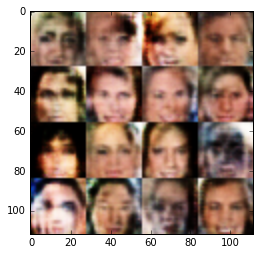

Epoch 1/3... Discriminator Loss: 0.9845... Generator Loss: 0.7074
Epoch 1/3... Discriminator Loss: 0.9010... Generator Loss: 0.8524
Epoch 1/3... Discriminator Loss: 0.9180... Generator Loss: 0.6617
Epoch 1/3... Discriminator Loss: 0.5710... Generator Loss: 1.3327
Epoch 1/3... Discriminator Loss: 1.3720... Generator Loss: 0.3505
Epoch 1/3... Discriminator Loss: 0.2298... Generator Loss: 3.1583
Epoch 1/3... Discriminator Loss: 1.7455... Generator Loss: 0.2521
Epoch 1/3... Discriminator Loss: 1.2675... Generator Loss: 0.7545
Epoch 1/3... Discriminator Loss: 1.3557... Generator Loss: 1.0345
Epoch 1/3... Discriminator Loss: 0.5849... Generator Loss: 1.9477
<class 'numpy.ndarray'>


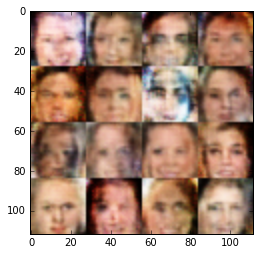

Epoch 1/3... Discriminator Loss: 1.4785... Generator Loss: 0.4708
Epoch 1/3... Discriminator Loss: 1.2200... Generator Loss: 1.3933
Epoch 1/3... Discriminator Loss: 0.8127... Generator Loss: 1.3462
Epoch 1/3... Discriminator Loss: 1.2727... Generator Loss: 0.7615
Epoch 1/3... Discriminator Loss: 1.6527... Generator Loss: 1.6431
Epoch 1/3... Discriminator Loss: 0.7986... Generator Loss: 2.0421
Epoch 1/3... Discriminator Loss: 1.3927... Generator Loss: 0.4313
Epoch 1/3... Discriminator Loss: 0.5363... Generator Loss: 2.4319
Epoch 1/3... Discriminator Loss: 0.7852... Generator Loss: 1.1213
Epoch 1/3... Discriminator Loss: 0.7892... Generator Loss: 1.8331
<class 'numpy.ndarray'>


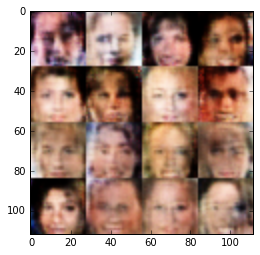

Epoch 1/3... Discriminator Loss: 1.2375... Generator Loss: 0.4199
Epoch 1/3... Discriminator Loss: 1.0677... Generator Loss: 1.3413
Epoch 1/3... Discriminator Loss: 1.4767... Generator Loss: 0.4694
Epoch 1/3... Discriminator Loss: 1.1227... Generator Loss: 0.6873
Epoch 1/3... Discriminator Loss: 1.3850... Generator Loss: 0.7105
Epoch 1/3... Discriminator Loss: 1.6535... Generator Loss: 0.3371
Epoch 1/3... Discriminator Loss: 0.4798... Generator Loss: 3.0303
Epoch 1/3... Discriminator Loss: 0.9093... Generator Loss: 1.8582
Epoch 2/3... Discriminator Loss: 0.9559... Generator Loss: 1.2747
Epoch 2/3... Discriminator Loss: 1.2173... Generator Loss: 0.9383
<class 'numpy.ndarray'>


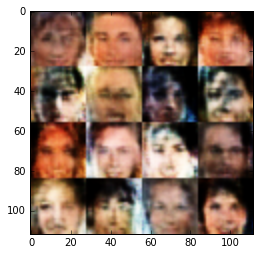

Epoch 2/3... Discriminator Loss: 1.1851... Generator Loss: 0.6325
Epoch 2/3... Discriminator Loss: 1.7384... Generator Loss: 0.2467
Epoch 2/3... Discriminator Loss: 0.7855... Generator Loss: 2.3473
Epoch 2/3... Discriminator Loss: 0.3267... Generator Loss: 2.4639
Epoch 2/3... Discriminator Loss: 0.4372... Generator Loss: 1.8683
Epoch 2/3... Discriminator Loss: 0.4266... Generator Loss: 3.9011
Epoch 2/3... Discriminator Loss: 0.3554... Generator Loss: 1.7158
Epoch 2/3... Discriminator Loss: 0.1665... Generator Loss: 2.9500
Epoch 2/3... Discriminator Loss: 0.6283... Generator Loss: 5.0184
Epoch 2/3... Discriminator Loss: 0.1798... Generator Loss: 3.7766
<class 'numpy.ndarray'>


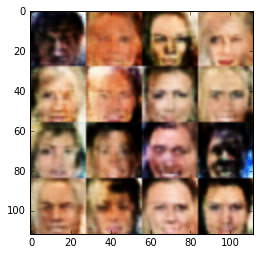

Epoch 2/3... Discriminator Loss: 1.2999... Generator Loss: 1.1056
Epoch 2/3... Discriminator Loss: 1.0633... Generator Loss: 0.9703
Epoch 2/3... Discriminator Loss: 1.3547... Generator Loss: 1.0882
Epoch 2/3... Discriminator Loss: 1.3708... Generator Loss: 0.6490
Epoch 2/3... Discriminator Loss: 1.2246... Generator Loss: 0.8636
Epoch 2/3... Discriminator Loss: 0.2013... Generator Loss: 3.1873
Epoch 2/3... Discriminator Loss: 1.3912... Generator Loss: 0.6895
Epoch 2/3... Discriminator Loss: 1.3135... Generator Loss: 2.4449
Epoch 2/3... Discriminator Loss: 1.4843... Generator Loss: 0.5819
Epoch 2/3... Discriminator Loss: 1.6167... Generator Loss: 0.3519
<class 'numpy.ndarray'>


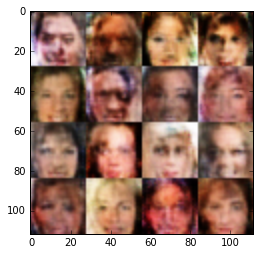

Epoch 2/3... Discriminator Loss: 0.8974... Generator Loss: 1.1771
Epoch 2/3... Discriminator Loss: 0.5580... Generator Loss: 2.3883
Epoch 2/3... Discriminator Loss: 0.5666... Generator Loss: 1.4379
Epoch 2/3... Discriminator Loss: 1.2394... Generator Loss: 0.7570
Epoch 2/3... Discriminator Loss: 0.4697... Generator Loss: 4.7816
Epoch 2/3... Discriminator Loss: 1.3627... Generator Loss: 0.5402
Epoch 2/3... Discriminator Loss: 0.2606... Generator Loss: 2.9354
Epoch 2/3... Discriminator Loss: 1.3919... Generator Loss: 0.8455
Epoch 2/3... Discriminator Loss: 0.5176... Generator Loss: 2.3690
Epoch 2/3... Discriminator Loss: 1.4161... Generator Loss: 0.5211
<class 'numpy.ndarray'>


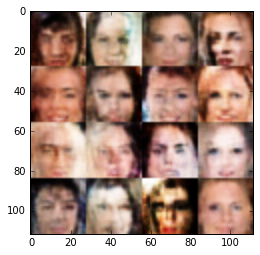

Epoch 2/3... Discriminator Loss: 0.6543... Generator Loss: 1.4451
Epoch 2/3... Discriminator Loss: 1.3169... Generator Loss: 0.5990
Epoch 2/3... Discriminator Loss: 0.1567... Generator Loss: 3.4083
Epoch 2/3... Discriminator Loss: 1.2537... Generator Loss: 0.8642
Epoch 2/3... Discriminator Loss: 1.1997... Generator Loss: 0.5887
Epoch 2/3... Discriminator Loss: 0.8760... Generator Loss: 1.2658
Epoch 2/3... Discriminator Loss: 1.1168... Generator Loss: 0.7924
Epoch 2/3... Discriminator Loss: 0.7871... Generator Loss: 0.8349
Epoch 2/3... Discriminator Loss: 0.9044... Generator Loss: 0.7378
Epoch 2/3... Discriminator Loss: 0.9455... Generator Loss: 0.9379
<class 'numpy.ndarray'>


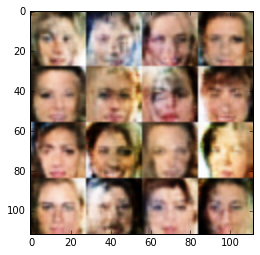

Epoch 2/3... Discriminator Loss: 0.7019... Generator Loss: 2.3309
Epoch 2/3... Discriminator Loss: 0.9080... Generator Loss: 2.6642
Epoch 2/3... Discriminator Loss: 0.8370... Generator Loss: 1.6079
Epoch 2/3... Discriminator Loss: 0.6802... Generator Loss: 1.0324
Epoch 2/3... Discriminator Loss: 0.7227... Generator Loss: 1.7732
Epoch 2/3... Discriminator Loss: 1.1205... Generator Loss: 1.0560
Epoch 2/3... Discriminator Loss: 0.4640... Generator Loss: 4.0310
Epoch 2/3... Discriminator Loss: 0.3455... Generator Loss: 2.6172
Epoch 2/3... Discriminator Loss: 0.5235... Generator Loss: 2.9069
Epoch 2/3... Discriminator Loss: 1.5517... Generator Loss: 1.1401
<class 'numpy.ndarray'>


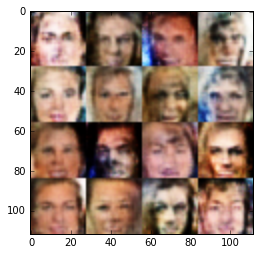

Epoch 2/3... Discriminator Loss: 0.9987... Generator Loss: 0.7038


KeyboardInterrupt: 

In [48]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.